# Tâche

Analysez et comparez les données sur la pollution de l'air de deux stations : l'une à New York (États-Unis) et l'autre à Bogota (Colombie). Extrayez des informations utiles et incluez des visualisations pour étayer vos conclusions.

Vous pouvez commencer par analyser les données de chaque station individuellement. Effectuez une analyse de séries chronologiques des niveaux de pollution. Quand la pollution est-elle la plus élevée et la plus basse ? Pouvez-vous identifier des tendances ou des schémas saisonniers ?

Ensuite, comparez la pollution PM2.5 dans les deux villes. À l'aide d'une visualisation, montrez à quels moments le niveau de pollution à New York est supérieur à celui de Bogota. Pouvez-vous repérer des tendances ou des schémas saisonniers ? Les deux séries chronologiques sont-elles corrélées ?

Il est également conseillé d'explorer les limites de pollution définies par l'Organisation mondiale de la santé (OMS), par exemple en vous basant sur ce document. Le niveau moyen annuel de pollution dans les deux villes est-il inférieur à la valeur acceptable définie par l'OMS ? Rédigez un algorithme pour détecter les moments où le niveau moyen de pollution sur 24 heures dépasse la valeur acceptable et utilisez une visualisation pour marquer ces périodes (camembert).

Ce ne sont que des suggestions sur ce que vous pouvez extraire de ces données. Après avoir analysé les ensembles de données, n'hésitez pas à faire preuve de créativité et à tirer des conclusions supplémentaires et pertinentes !


#### Table des matières :

- [Nettoyage des données](#nettoyage-des-donnees)
- [Visualisation et comparaison entre NY et Bogota](#visualisation-et-comparaison-entre-ny-et-bogota)
- [Filtrage des données par jour/mois, puis entre 2016 et 2017](#filtrage-des-donnees-par-jourmois-puis-entre-2016-et-2017)
- [Les 5 jours où le pm2.5 est le plus élevé (NY & Bogota)](#les-5-jours-ou-le-pm25-est-le-plus-eleve-ny--bogota)
- [Les jours où NY a un pm2.5 plus élevé que Bogota](#les-jours-ou-ny-a-un-pm25-plus-eleve-que-bogota)
- [Test rapide des valeurs pm10 de Bogota](#test-rapide-des-valeurs-pm10-de-bogota)
- [Vérification saisonnières par station](#verification-saisonnieres-par-station)
- [Vérification de la corrélation entre NY et Bogota](#verification-de-la-correlation-entre-ny-et-bogota)
- [Focus avec le document pdf, le ratio entre pm2.5 et pm10 doit être entre 0.5 et 0.8](#focus-avec-le-document-pdf-le-ratio-entre-pm25-et-pm10-doit-etre-entre-05-et-08)
- [Définition des valeurs de référence ou intermédiaires et répartition de ces indicateurs](#definition-des-valeurs-de-reference-ou-intermediaires-et-repartition-de-ces-indicateurs)



In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Nettoyage des données

- Les données de manière générale ont des espaces partout, le format txt de base aide un peu de ce côté là. Il manque toute la colonne de station qui peut être utile
- Les dates de Bogota sont au format 24h, c'est bien, mais certaines dates s'affiche au format 31/08/2024 24:00, ce qui n'est pas un bon format
- Les dates de NY s'affichent au format AM/PM
- Les dates de Bogota s'affichent au format 'Y-m-d' et celles de NY au format 'Y/m/d"
- Le nom de la station de bogota et tout son fichier est hispanique
- Il y a des valeurs inutiles en 1ere position et sur les 8 dernières
- Le df de bogota comporte des NaN qu'on va supprimer
- Le df de NY n'a pas les valeurs pm10
- Les valeurs dans le df de Bogota ne sont pas numériques car séparées par des virgules

In [28]:
#Importation des données de Bogota
df_bogota = pd.read_csv('./datasetclients/pollution/bogota.txt', sep="|")

#Suppression des lignes inutiles
df_bogota.drop(df_bogota.tail(8).index, inplace=True)
df_bogota.drop(df_bogota.head(1).index, inplace=True)

#Suppression des espaces dans les noms de colonnes pour renommage
df_bogota.columns = df_bogota.columns.str.strip()

#Suppression des espaces inutiles dans absolument toutes les lignes du df
df_bogota = df_bogota.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#Renommage des colonnes
df_bogota.rename(columns={'Estación:San Cristobal -' : 'station', 'Fecha y Hora' : "date", 'PM2.5' : 'pm25', 'PM10' : 'pm10'}, inplace=True)

#Je remplie la colonne station au cas où on souhaite fusionner plus tard
df_bogota['station'] = "Bogota"

#Je remplace les valeurs à virgules par des points pour transformer en numérique
df_bogota['pm25'] = pd.to_numeric(df_bogota['pm25'].str.replace(',', '.'))
df_bogota['pm10'] = pd.to_numeric(df_bogota['pm10'].str.replace(',', '.'))

#Je vire les valeurs nulles
df_bogota = df_bogota.dropna()

#------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------

#Importation des données de NY
df_ny = pd.read_csv('./datasetclients/pollution/ny.txt', sep="|")

#Suppression des lignes inutiles
df_ny.drop(df_ny.tail(8).index, inplace=True)
df_ny.drop(df_ny.head(1).index, inplace=True)

#Suppression des espaces dans les noms de colonnes pour renommage
df_ny.columns = df_ny.columns.str.strip()
df_ny.rename(columns={'Station:Queens College -' : 'station', 'Date Time' : "date", 'PM25FEM' : 'pm25'}, inplace=True)

#Je remplie la colonne station au cas où on souhaite fusionner plus tard
df_ny['station'] = "NY"

#Suppression des espaces inutiles dans absolument toutes les lignes du df
df_ny = df_ny.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#Je manipule les dates pour avoir des formats 24h cohérents
df_ny['date'] = pd.to_datetime(df_ny['date'], format='%m/%d/%Y %I:%M %p').dt.strftime('%d-%m-%Y %H:%M')
df_ny['date'] = pd.to_datetime(df_ny['date'])

#Je transforme le pm2.5 en format numérique, cette fois pas besoin de changer la virgule par un point
df_ny['pm25'] = pd.to_numeric(df_ny['pm25'])

Je traite ici le fait que le df de bogota a des horaires à 24h, je replace ça à minuit et j'ajouterais donc une journée à la date en question

In [29]:
#Le DF de Bogota affiche des heures à 24:00, il faut traiter ça
def fix_date(date):
    if '24:00' in date:
        corrected_date = pd.to_datetime(date.replace('24:00', '00:00')) + pd.Timedelta(days=1)
        return corrected_date
    else:
        return pd.to_datetime(date)

df_bogota['date'] = df_bogota['date'].apply(fix_date)
df_bogota['date'] = pd.to_datetime(df_ny['date'])

On finit par créer le df fusionné, qui va nous servir pour tout

In [4]:
#Je crée maintenant le df fusionné, à voir si j'ai besoin de m'en servir
df_final = pd.concat([df_bogota, df_ny], axis=0, ignore_index=True)
df_final

,station,date,pm25,pm10
0,Bogota,2016-01-09 00:00:00,6.0,3.9
1,Bogota,2016-01-09 01:00:00,7.9,4.9
2,Bogota,2016-01-09 02:00:00,7.3,8.0
3,Bogota,2016-01-09 03:00:00,2.5,8.1
4,Bogota,2016-01-09 04:00:00,6.5,7.3
...,...,...,...,...
9950,NY,2017-03-31 20:00:00,-0.9,NaN
9951,NY,2017-03-31 21:00:00,0.2,NaN
9952,NY,2017-03-31 22:00:00,1.8,NaN
9953,NY,2017-03-31 23:00:00,1.5,NaN


In [25]:
def assign_season(month):
    if month in [12, 1, 2]:
        return "Hiver"
    elif month in [3, 4, 5]:
        return "Printemps"
    elif month in [6, 7, 8]:
        return "Été"
    else:
        return "Automne"

## Aggregation des données et premières comparaison entre NY et Bogota

L'objectif est de faire plusieurs comparaisons entre les différentes villes, ça nous permettra également de voir les infos pour chaque villes. 

Je vais commencer par filtrer et grouper mes tableaux par dates, et sortir les moyennes du pm2.5. D'après le document pdf, c'est intéressant de regarder les moyennes journalières et annuelles. On vérifiera plus tard ces informations en détails, mais ici on va pouvoir faire une visu rapide

Je vais ajouter des colonnes à mon df_final pour pouvoir gérer mes groupby, j'ajoute l'année, le n° du mois, la saison, une date avec uniquement le mois et l'année, une date complète, et les heures

In [30]:
df_final['year'] = df_final['date'].dt.year
df_final['nbmonth'] = df_final['date'].dt.month

#Je groupe par saison et moyenne du pm2.5, ça sera utile plus tard
df_final['season'] = df_final['nbmonth'].apply(assign_season)
df_final_saison = df_final.groupby(['station', 'season']).pm25.mean().reset_index()


df_final['month'] = df_final['date'].dt.strftime('%m-%Y')
df_final_month = df_final.groupby(['station', 'month']).pm25.mean().reset_index()
df_final_month = df_final_month.sort_values(by="month")


df_final['day'] = df_final['date'].dt.strftime('%d-%m-%Y')
df_final_day = df_final.groupby(['station', 'day']).pm25.mean().reset_index()
df_final_day = df_final_day.sort_values(by="day")


df_final['hour'] = df_final['date'].dt.hour
df_final_hour = df_final.groupby(['station', 'hour']).pm25.mean().reset_index()

df_final_nbmonth = df_final.groupby(['station', 'nbmonth']).pm25.mean().reset_index()

df_final

,station,date,pm25,pm10,year,nbmonth,season,month,day,hour
0,Bogota,2016-01-09 00:00:00,6.0,3.9,2016.0,1.0,Hiver,01-2016,09-01-2016,0.0
1,Bogota,2016-01-09 01:00:00,7.9,4.9,2016.0,1.0,Hiver,01-2016,09-01-2016,1.0
2,Bogota,2016-01-09 02:00:00,7.3,8.0,2016.0,1.0,Hiver,01-2016,09-01-2016,2.0
3,Bogota,2016-01-09 03:00:00,2.5,8.1,2016.0,1.0,Hiver,01-2016,09-01-2016,3.0
4,Bogota,2016-01-09 04:00:00,6.5,7.3,2016.0,1.0,Hiver,01-2016,09-01-2016,4.0
...,...,...,...,...,...,...,...,...,...,...
9950,NY,2017-03-31 20:00:00,-0.9,NaN,2017.0,3.0,Printemps,03-2017,31-03-2017,20.0
9951,NY,2017-03-31 21:00:00,0.2,NaN,2017.0,3.0,Printemps,03-2017,31-03-2017,21.0
9952,NY,2017-03-31 22:00:00,1.8,NaN,2017.0,3.0,Printemps,03-2017,31-03-2017,22.0
9953,NY,2017-03-31 23:00:00,1.5,NaN,2017.0,3.0,Printemps,03-2017,31-03-2017,23.0


Je crée ensuite deux premiers lineplots pour voir si il y a des n° de mois et des horaires propices à une grosse émission. ça va me permettre de voir une première tendance avant de vérifier les émissions journalières, mensuelles etc. J'affiche les deux stations pour comparer

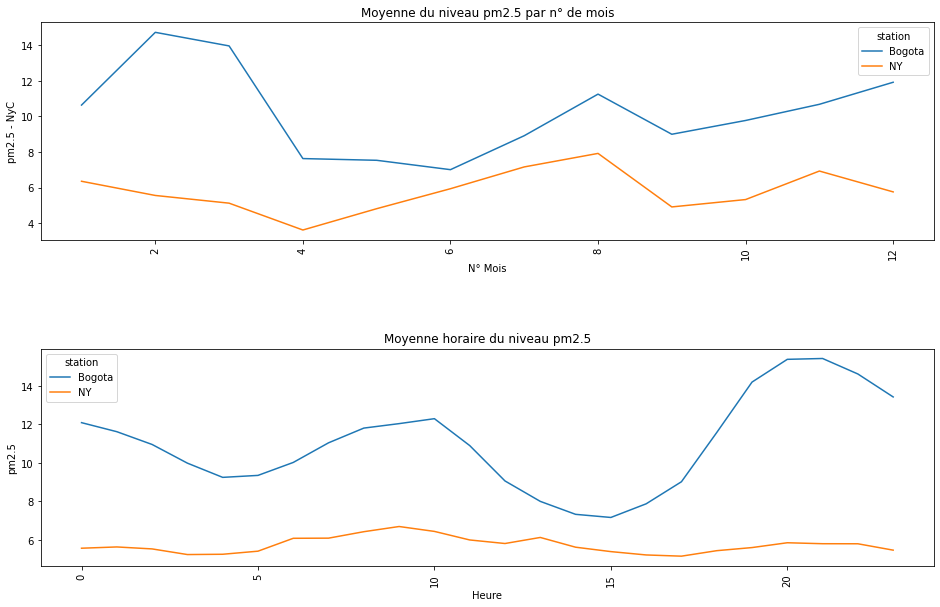

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes = axes.ravel()

sns.lineplot(data=df_final_nbmonth, x='nbmonth', y='pm25', hue='station', ax=axes[0])
axes[0].set_xlabel('N° Mois')
axes[0].set_ylabel('pm2.5 - NyC')
axes[0].set_title('Moyenne du niveau pm2.5 par n° de mois')
axes[0].tick_params(axis='x', rotation=90)

sns.lineplot(data=df_final_hour, x='hour', y='pm25', hue='station', ax=axes[1])
axes[1].set_xlabel('Heure')
axes[1].set_ylabel('pm2.5')
axes[1].set_title('Moyenne horaire du niveau pm2.5')
axes[1].tick_params(axis='x', rotation=90)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

Pas énormément d'informations à tirer de ça, mis à part que le niveau d'emission de Bogota est nettement supérieur à celui de NY. Le point intéressant est de noter qu'autour de 18h-21h à bogota, les emissions explosent. On peut le relier à l'heure de pointe

## Filtrage des données par jour/mois, puis entre 2016 et 2017

On va pouvoir comparer les données entre les stations, et pouvoir préciser entre 2016 et 2017 au vu de la quantité de données

In [8]:
df_final_day['day'] = pd.to_datetime(df_final_day['day'])
df_final_month['month'] = pd.to_datetime(df_final_month['month'])

df_final_day_2016 = df_final_day.loc[df_final_day['day'].dt.year == 2016]
df_final_day_2017 = df_final_day.loc[df_final_day['day'].dt.year == 2017]

df_final_month_2016 = df_final_month.loc[df_final_month['month'].dt.year == 2016]
df_final_month_2017 = df_final_month.loc[df_final_month['month'].dt.year == 2017]

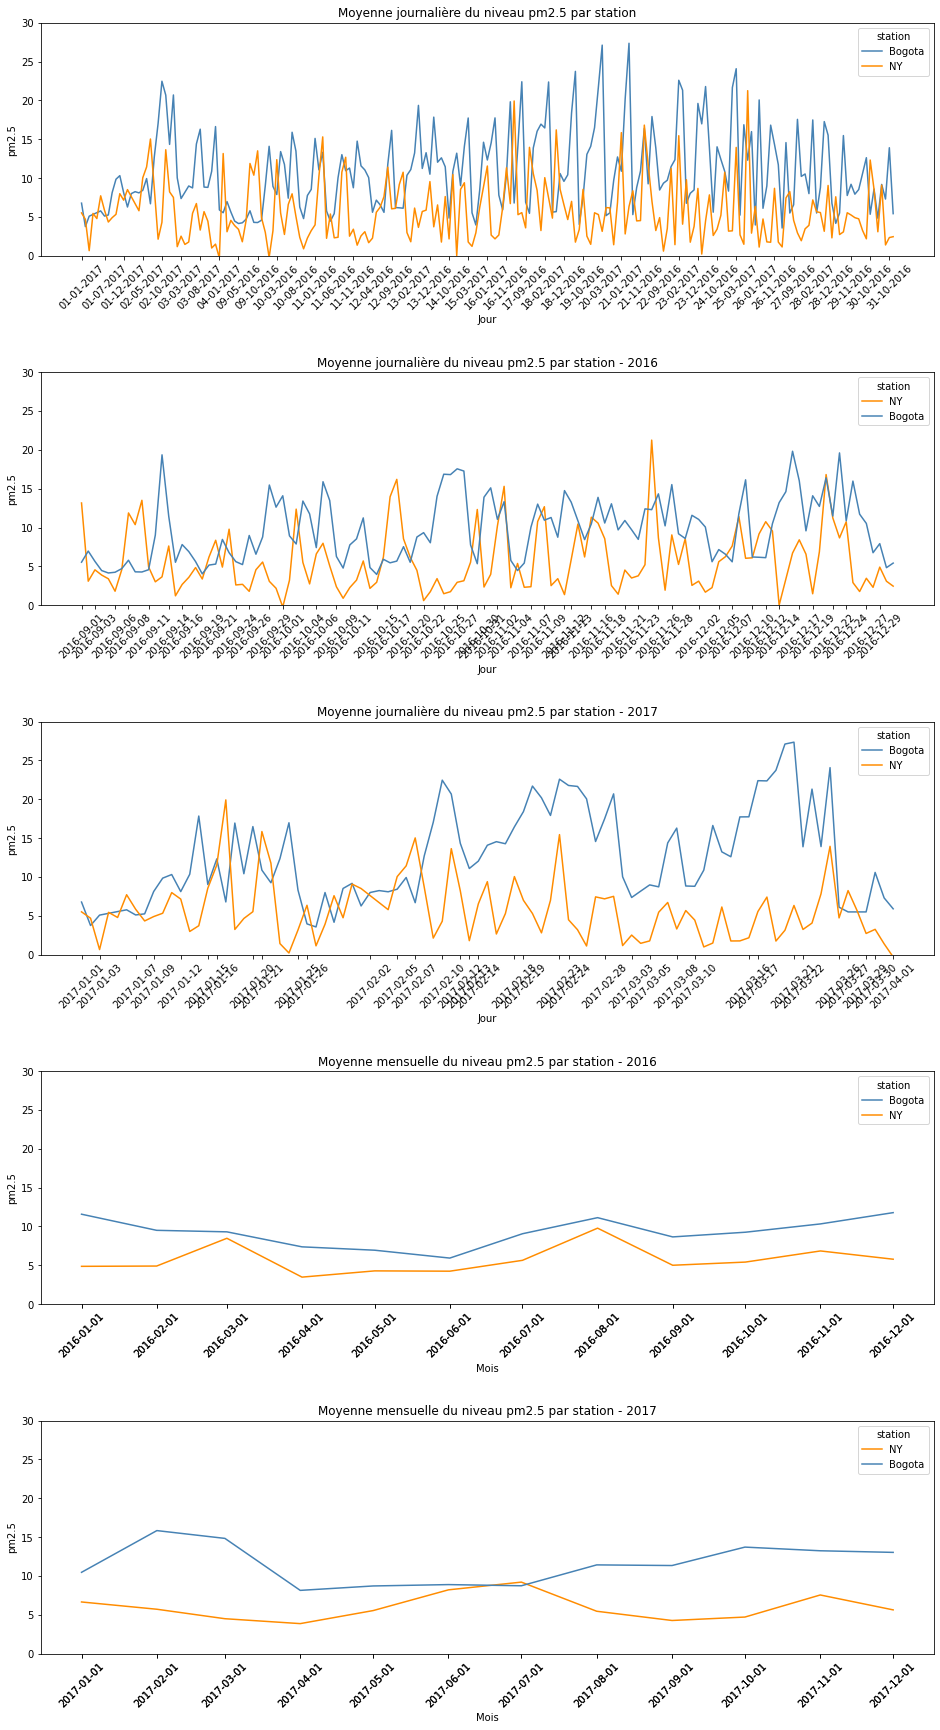

In [35]:
fig, axes = plt.subplots(5, 1, figsize=(16, 30))
axes = axes.ravel()

station_colors = {'Bogota': 'steelblue', 'NY': 'darkorange'}

sns.lineplot(data=df_final_day, x='day', y='pm25', hue='station', ax=axes[0], palette=station_colors)
axes[0].set_xlabel('Jour')
axes[0].set_xticks(df_final_day['day'][::10])
axes[0].set_ylabel('pm2.5')
axes[0].set_ylim(0, 30)
axes[0].set_title('Moyenne journalière du niveau pm2.5 par station')
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_final_day_2016, x='day', y='pm25', hue='station', ax=axes[1], palette=station_colors)
axes[1].set_xlabel('Jour')
axes[1].set_xticks(df_final_day_2016['day'][::5])
axes[1].set_ylabel('pm2.5')
axes[1].set_ylim(0, 30)
axes[1].set_title('Moyenne journalière du niveau pm2.5 par station - 2016')
axes[1].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_final_day_2017, x='day', y='pm25', hue='station', ax=axes[2], palette=station_colors)
axes[2].set_xlabel('Jour')
axes[2].set_xticks(df_final_day_2017['day'][::5])
axes[2].set_ylabel('pm2.5')
axes[2].set_ylim(0, 30)
axes[2].set_title('Moyenne journalière du niveau pm2.5 par station - 2017')
axes[2].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_final_month_2016, x='month', y='pm25', hue='station', ax=axes[3], palette=station_colors)
axes[3].set_xlabel('Mois')
axes[3].set_xticks(df_final_month_2016['month'][::1])
axes[3].set_ylabel('pm2.5')
axes[3].set_ylim(0, 30)
axes[3].set_title('Moyenne mensuelle du niveau pm2.5 par station - 2016')
axes[3].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_final_month_2017, x='month', y='pm25', hue='station', ax=axes[4], palette=station_colors)
axes[4].set_xlabel('Mois')
axes[4].set_xticks(df_final_month_2017['month'][::1])
axes[4].set_ylabel('pm2.5')
axes[4].set_ylim(0, 30)
axes[4].set_title('Moyenne mensuelle du niveau pm2.5 par station - 2017')
axes[4].tick_params(axis='x', rotation=45)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

De manière générale, Bogota a une plus grosse emission globale, mais NY a quelques pics où ils dépassent. Derrière, pas spécialement de tendance à noter. 
On va donc calculer les 5 jours où le pm2.5 est le plus élevé, et on va également voir les moments où NY a une plus grosse emission que Bogota

## Les 5 jours où le pm2.5 est le plus élevé (NY & Bogota)

In [36]:
top_days = df_final_day.copy()

top_5 = top_days.sort_values(by=['station', 'pm25'], ascending=[True, False])
top_5 = top_5.groupby('station').head(5)

top_5

,station,day,pm25
141,Bogota,21-03-2017,27.358333
134,Bogota,20-03-2017,27.116667
169,Bogota,25-03-2017,24.079167
127,Bogota,19-03-2017,23.737500
154,Bogota,23-02-2017,22.591667
385,NY,25-11-2016,21.254167
324,NY,17-01-2017,19.925000
358,NY,21-12-2016,16.818182
335,NY,18-10-2016,16.200000
352,NY,21-01-2017,15.850000


Le mois de Mars 2017 est visiblement un gros mois pour Bogota en terme d'emission. Côté NY, les dates sont plus éparses et ne semblent pas avoir de grand sens

## Les jours où NY a un pm2.5 plus élevé que Bogota

In [11]:
df_ny = df_final[df_final['station'] == 'NY']
df_bogota = df_final[df_final['station'] == 'Bogota']

df_ny_grouped = df_ny.groupby('day')['pm25'].mean().reset_index().rename(columns={'pm25': 'pm25_ny'})
df_bogota_grouped = df_bogota.groupby('day')['pm25'].mean().reset_index().rename(columns={'pm25': 'pm25_bogota'})

df_result = pd.merge(df_ny_grouped, df_bogota_grouped, on='day')
df_result = df_result.dropna()

df_result["difference"] = df_result["pm25_ny"] - df_result["pm25_bogota"]

df_ny_over_bogota = df_result.loc[df_result['difference'] > 0]
df_ny_over_bogota = df_ny_over_bogota.sort_values(by="difference", ascending=False)

df_ny_over_bogota.head()

,day,pm25_ny,pm25_bogota,difference
111,17-01-2017,19.925000,6.784615,13.140385
122,18-10-2016,16.200000,5.675000,10.525000
44,09-10-2016,13.504167,4.272727,9.231439
172,25-11-2016,21.254167,12.300000,8.954167
115,17-10-2016,13.956522,5.454167,8.502355


## Test rapide des valeurs pm10 de Bogota

In [12]:
df_copy = df_final.copy()

pm10bogota = df_copy.loc[df_copy['station'] == "Bogota"]
pm10bogota.drop(pm10bogota.tail(23).index, inplace=True)

pm10bogota_month = pm10bogota.groupby('month').pm10.mean().reset_index()
pm10bogota_day = pm10bogota.groupby('day').pm10.mean().reset_index()
pm10bogota_hour = pm10bogota.groupby('hour').pm10.mean().reset_index()

F:\Users\Thomas\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


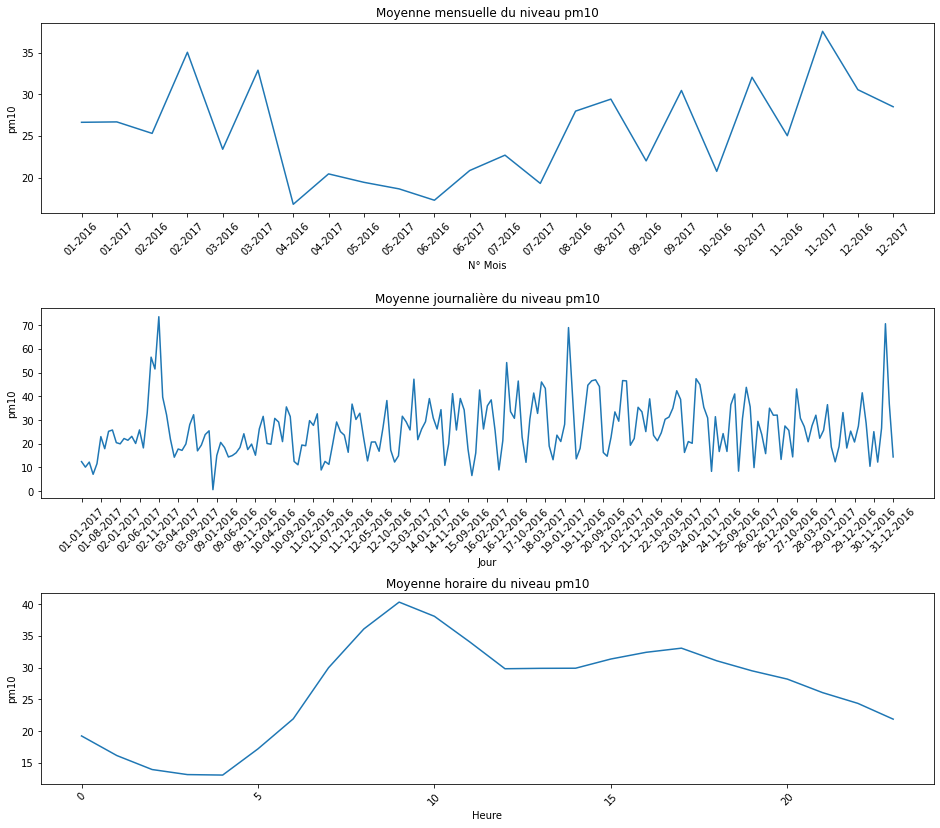

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
axes = axes.ravel()

sns.lineplot(data=pm10bogota_month, x='month', y='pm10', ax=axes[0])
axes[0].set_xlabel('N° Mois')
axes[0].set_ylabel('pm10')
axes[0].set_title('Moyenne mensuelle du niveau pm10')
axes[0].tick_params(axis='x', rotation=45)


sns.lineplot(data=pm10bogota_day, x='day', y='pm10', ax=axes[1])
axes[1].set_xlabel('Jour')
axes[1].set_xticks(pm10bogota_day['day'][::5])
axes[1].set_ylabel('pm10')
axes[1].set_title('Moyenne journalière du niveau pm10')
axes[1].tick_params(axis='x', rotation=45)


sns.lineplot(data=pm10bogota_hour, x='hour', y='pm10', ax=axes[2])
axes[2].set_xlabel('Heure')
axes[2].set_ylabel('pm10')
axes[2].set_title('Moyenne horaire du niveau pm10')
axes[2].tick_params(axis='x', rotation=45)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Vérification saisonières par station

On veut vérifier les différences avec les valeurs de saison

In [14]:
df_final_saison_pm10 = df_final.groupby(['station', 'season']).pm10.mean().reset_index()
df_final_saison_pm10 = df_final_saison_pm10.dropna()

### Barplots

A gauche la comparaison pm2.5 entre les stations, à droite le pm10 de bogota

On notera qu'à Bogota, l'hiver est la période la plus polluée avec le printemps, là où à NY, c'est l'été qui est largement plus élevé

Text(0.5, 1.0, 'PM10 par saison à Bogota')

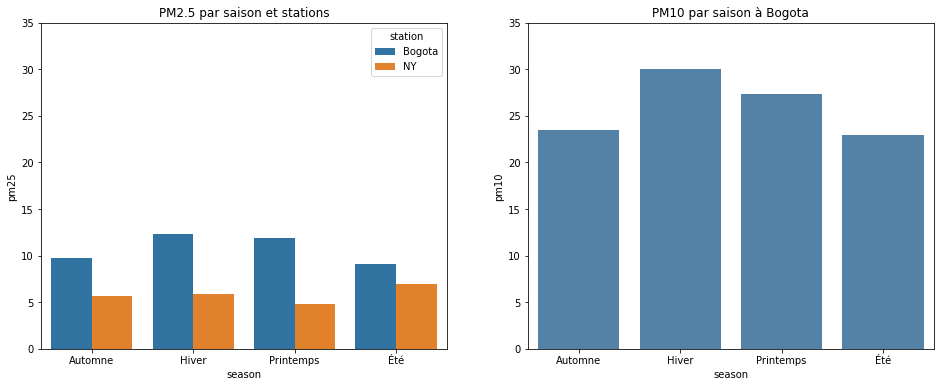

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df_final_saison, x="season", y="pm25", hue="station", ax=axes[0])
axes[0].set_ylim(0, 35)
axes[0].set_title("PM2.5 par saison et stations")

sns.barplot(data=df_final_saison_pm10, x="season", y="pm10", color="steelblue", ax=axes[1])
axes[1].set_ylim(0, 35)
axes[1].set_title("PM10 par saison à Bogota")

## Vérification de la correlation entre NY et Bogota

In [16]:
corr_pm25_pm10 = df_result['pm25_ny'].corr(df_result['pm25_bogota'])
print(f"Corrélation entre NY et Bogota (pm2.5) : {corr_pm25_pm10}")

Corrélation entre NY et Bogota (pm2.5) : 0.007872436957495588


Une correlation a 0 montre qu'il n'y a absolument aucune correlation linéaire entre les données

## Focus avec le document pdf, le ratio entre pm2.5 et pm10 doit être entre 0.5 et 0.8

In [17]:
df_bogota['ratio'] = df_bogota['pm25'] / df_bogota['pm10']
df_bogota.drop(df_bogota.tail(29).index, inplace=True)

print(df_bogota['ratio'].describe())

count    4837.000000
mean        0.570730
std         0.720484
min         0.000000
25%         0.264582
50%         0.455959
75%         0.689516
max        18.666667
Name: ratio, dtype: float64


C:\Users\Thomas\AppData\Local\Temp/ipykernel_25856/594841504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bogota['ratio'] = df_bogota['pm25'] / df_bogota['pm10']
F:\Users\Thomas\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


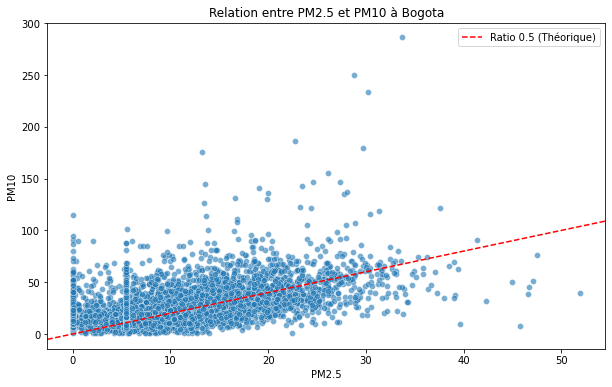

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_bogota, x='pm25', y='pm10', alpha=0.6)
plt.axline((0, 0), slope=2, color='red', linestyle='--', label='Ratio 0.5 (Théorique)')
plt.xlabel('PM2.5')
plt.ylabel('PM10')
plt.title('Relation entre PM2.5 et PM10 à Bogota')
plt.legend()
plt.show()

## Définition des valeurs de références ou intermédiaires et répartition de ces indicateurs

In [19]:
def set_indicator_anual(pm25):
    if pm25 <= 10:
        return "REF"
    if pm25 <= 15:
        return "IT-3"
    if pm25 <= 25:
        return "IT-"
    if pm25 > 25:
        return "IT-1"    
    
def set_indicator_daily(pm25):
    if pm25 <= 25:
        return "REF"
    if pm25 <= 37.5:
        return "IT-3"
    if pm25 <= 50:
        return "IT-"
    if pm25 > 50:
        return "IT-1"   

df_final_day = df_final.groupby(['station', 'day']).pm25.mean().reset_index()
df_final_day['indicator'] = df_final_day['pm25'].apply(set_indicator_daily)

df_final_year = df_final.groupby(['station', 'year']).pm25.mean().reset_index()
df_final_year['indicator'] = df_final_year['pm25'].apply(set_indicator_anual)

df_final_day

,station,day,pm25,indicator
0,Bogota,01-01-2017,6.769565,REF
1,Bogota,01-02-2017,3.750000,REF
2,Bogota,01-03-2017,5.088235,REF
3,Bogota,01-06-2017,5.771429,REF
4,Bogota,01-07-2017,5.108333,REF
...,...,...,...,...
419,NY,30-12-2016,3.083333,REF
420,NY,31-01-2017,9.085714,REF
421,NY,31-03-2017,1.387500,REF
422,NY,31-10-2016,2.337500,REF


In [20]:
df_indicator_day_ny = df_final_day.loc[df_final_day['station'] == "NY"]
df_indicator_day_ny = df_indicator_day_ny.groupby('indicator').mean().reset_index()

df_indicator_day_bogota = df_final_day.loc[df_final_day['station'] == "Bogota"]
df_indicator_day_bogota = df_indicator_day_bogota.groupby('indicator').mean().reset_index()

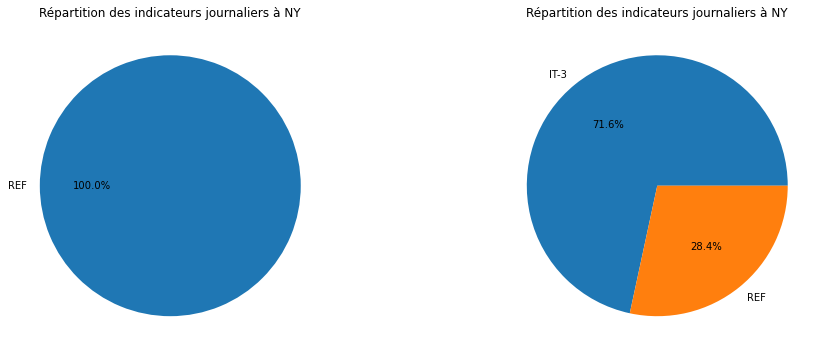

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].pie(df_indicator_day_ny['pm25'], labels=df_indicator_day_ny['indicator'], autopct="%1.1f%%")
axes[0].set_title("Répartition des indicateurs journaliers à NY")

axes[1].pie(df_indicator_day_bogota['pm25'], labels=df_indicator_day_bogota['indicator'], autopct="%1.1f%%")
axes[1].set_title("Répartition des indicateurs journaliers à NY")

plt.show()